In [5]:
GPU = False

if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
else:
    import numpy as np

In [6]:
# optimizer
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [21]:
def MSE(y, t):
    return 0.5*np.mean((y-t)**2)

class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        y = x.copy()
        y[self.mask] = 0

        return y
    
    def backward(self, dy):
        dy[self.mask] = 0
        dx = dy

        return dy


class TimeFC:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        N, T, D = x.shape

        reshaped_x = x.reshape(N*T, -1)
        y = np.dot(reshaped_x, W) + b
        
        self.x = x
        y = y.reshape(N, T, -1)
        return y

    def backward(self, dy):
        W, b = self.params
        x = self.x
        N, T, D = x.shape

        dy = dy.reshape(N*T, -1)
        reshaped_x = x.reshape(N*T, -1)

        db = np.sum(dy, axis=0)
        dx = np.matmul(dy, W.T)
        dW = np.matmul(reshaped_x.T, dy)
        
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

class TimeMSE:
    def __init__(self):
        self.params, self.grads = [], []
        self.activation = ReLU()
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        xs = xs.reshape(N*T, V)
        xs = self.activation.forward(xs)

        ts = ts.reshape(N*T, V)

        loss = MSE(xs, ts)
        self.cache = (ts, xs, (N, T, V))

        return loss

    def backward(self, dy = 1):

        ts, xs, (N, T, V) = self.cache
        
        dx = dy * (xs - ts) / (N*T)

        dx = self.activation.backward(dx)
        dx = dx.reshape(N ,T, V)
        return dx

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        # Affine transformation (Wx[f, g, i, o], Wh[f, g, i, o], b[f, g, i, o])
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        # slice for gates and get
        forget = A[:, :H]       # NxH
        get = A[:, H:2*H]
        input = A[:, 2*H:3*H]
        output = A[:, 3*H:4*H]

        forget = sigmoid(forget)   # forget gate
        get = np.tanh(get)        # new memory
        input = sigmoid(input)    # input gate
        output = sigmoid(output)    # output gate

        c_next = (c_prev * forget) + (get * input)
        h_next = np.tanh(c_next) * output

        self.cache = (x, h_prev, c_prev, input, forget, get, output, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, input, forget, get, output, c_next = self.cache

        # chain rule
        do = dh_next * np.tanh(c_next)
        do_s = do * output*(1-output)
        dt = dh_next * output
        dt_c = dt * (1-(np.tanh(c_next)**2))

        di = dt_c * get
        dg = dt_c * input
        di_s = di * input*(1-input)
        dg_t = dg * (1-(get**2))

        dc_prev = dt_c * forget
        df = dt_c * c_prev
        df_s = df * forget*(1-forget)

        dA = np.hstack((df_s, dg_t, di_s, do_s))

        db = np.sum(dA, axis = 0)
        dWh = np.matmul(h_prev.T, dA)
        dh_prev = np.matmul(dA, Wh.T)
        dWx = np.matmul(x.T, dA)
        dx = np.matmul(dA, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev, dc_prev

In [10]:
# Time LSTM
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None      # for LSTM layer
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape      # mini-batch, time length, Dimension
        H = Wh.shape[0]         # Wh (H, 4H) H: hidden size
        
        self.layers = []        # for stacking LSTM layer (horizontal)
        hs = np.empty((N, T, H), dtype='f')   # for save (h0 ... ht)
        
        # if not stateful, initialize h and c
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs
        
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]   #dWx, dWh, db
        for t in reversed(range(T)):  # BPTT
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:,t ,:] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs
    

In [11]:
class Model:
    def __init__(self, time_size, hidden_size, feature_size):
        T, H, F = time_size, hidden_size, feature_size
        rand = np.random.randn

        # weights (Xavier)
        lstm_Wx = (rand(F, 4*H)/ np.sqrt(F)).astype('f')
        lstm_Wh = (rand(H, 4*H)/ np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')

        # He
        fc_W = (rand(H, 1)/ np.sqrt(2/H)).astype('f')
        fc_b = np.zeros(1).astype('f')

        # layer
        self.layers = [
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeFC(fc_W, fc_b)
        ]
        self.loss_layer = TimeMSE()

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads


    def predict(self, xs):
        xs = np.array(xs)
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        xs = np.array(xs)
        ts = np.array(ts)
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dy = 1):
        dy = self.loss_layer.backward(dy)
        for layer in reversed(self.layers):
            dy = layer.backward(dy)
        return dy

    def reset_state(self):
        self.layers[0].reset_state()

In [12]:
import pandas as pd
from datetime import datetime

df_parser = lambda x: datetime.strptime(x, '%Y %m %d %H')    # string to datetime
# data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
df = pd.read_csv(data_url, sep=',', parse_dates=[['year', 'month', 'day', 'hour']], date_parser=df_parser, index_col=0)

del df['No']
df.columns = ['pm2.5', 'dewp', 'temp', 'pres', 'cbwd','wind_speed', 'snow', 'rain']
df = df[24:]            # NaN values in first 24hours
df.head()

,pm2.5,dewp,temp,pres,cbwd,wind_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [14]:
# use others
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy

dataset = df.values
encoder = LabelEncoder()        # for cbwd : wind direction
dataset[:, 4] = encoder.fit_transform(dataset[:, 4])
dataset = dataset.astype('float')

reframed = series_to_supervised(dataset, 1, 1)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

values = reframed.values
n_train_hours = 320 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:5*n_train_hours, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_x = scaler_x.fit_transform(train_X)
scaled_y = scaler_y.fit_transform(train_y.reshape(-1, 1))

test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = scaled_x.reshape(-1 ,24, 8)
train_y = train_y.reshape(-1, 24, 1)
test_X = test_X.reshape(-1, 24, 8)
test_y = test_y.reshape(-1, 24, 1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)  var1(t)
1      129.0      -16.0       -4.0  ...        0.0        0.0    148.0
2      148.0      -15.0       -4.0  ...        0.0        0.0    159.0
3      159.0      -11.0       -5.0  ...        0.0        0.0    181.0
4      181.0       -7.0       -5.0  ...        1.0        0.0    138.0
5      138.0       -7.0       -5.0  ...        2.0        0.0    109.0

[5 rows x 9 columns]
(7680, 1, 8) (7680,) (30720, 1, 8) (30720,)
(320, 24, 8) (320, 24, 1) (1280, 24, 8) (1280, 24, 1)


In [43]:
import time

# 80 train, 20 test
batch_size = 64
hidden_size = 100
time_size = 24

learning_rate = 0.01
epochs = 100

model = Model(time_size, hidden_size, 8)
optimizer = Adam(learning_rate)

# traning 
start_time = time.time()

data_length = len(train_X)      # train_data
iter_len = data_length // batch_size
loss_arr=[]

for epoch in range(1, epochs+1):
    losses = 0

    for iter in range(iter_len):
        idx = iter*batch_size
        
        batch_x = train_X[idx:idx+batch_size]
        batch_t = train_y[idx:idx+batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = model.params, model.grads
        optimizer.update(params, grads)

        losses += loss.item()
        during = time.time() - start_time

    if epoch%10==0:    
        print(f'epoch : {epoch}/{epochs}, 시간 {during:.2f}[s],  loss: {loss.item():.5f}')
    loss_arr.append(losses/iter_len)

epoch : 10/100, 시간 5.85[s],  loss: 2448.51441
epoch : 20/100, 시간 11.62[s],  loss: 1496.52160
epoch : 30/100, 시간 17.55[s],  loss: 1085.21274
epoch : 40/100, 시간 23.36[s],  loss: 845.78233
epoch : 50/100, 시간 29.32[s],  loss: 1032.89535
epoch : 60/100, 시간 35.24[s],  loss: 629.20650
epoch : 70/100, 시간 41.17[s],  loss: 505.30031
epoch : 80/100, 시간 47.14[s],  loss: 515.05857
epoch : 90/100, 시간 53.00[s],  loss: 398.96897
epoch : 100/100, 시간 58.87[s],  loss: 394.28594
[4533.8010586766295, 2938.826098099621, 3111.689905110773, 3275.6171404486304, 2724.2942776397786, 2313.2901448398325, 2061.119956012921, 1862.174758115245, 1674.8183856738997, 1617.4849268696478, 1471.9225295259807, 1495.320701967798, 1633.4242236550024, 1939.1151775141984, 1963.0701124508676, 1754.6422389039217, 1597.5739969614078, 1237.4961065026525, 1370.6459544182376, 1086.1034169257443, 1033.4710191328434, 991.9072701158096, 915.7615603602669, 900.5625473363204, 863.3120188298853, 826.011126626024, 847.8554068000489, 808.908

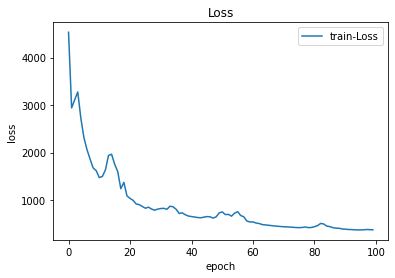

In [44]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), loss_arr, label='train-Loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

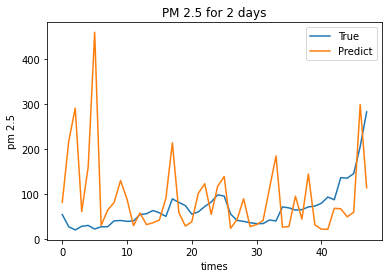

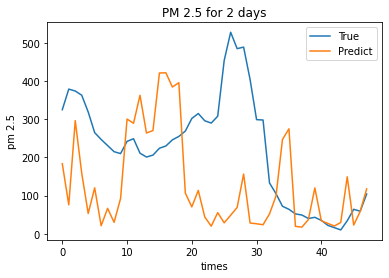

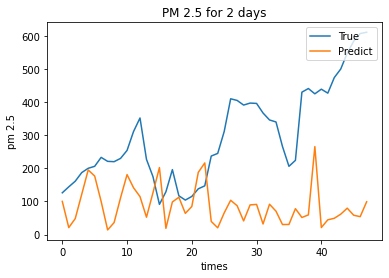

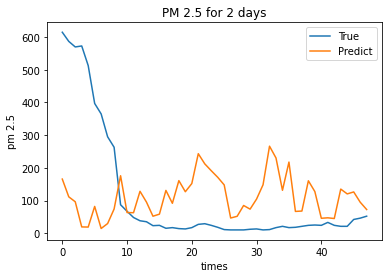

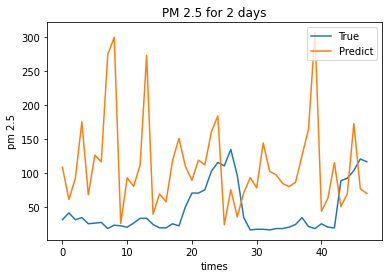

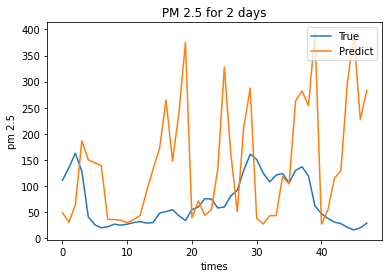

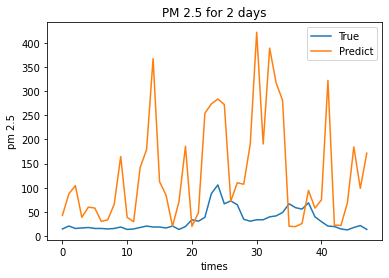

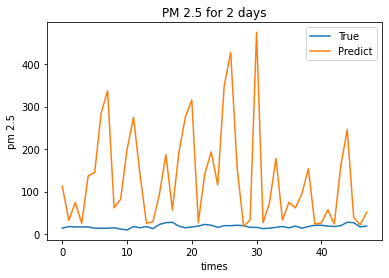

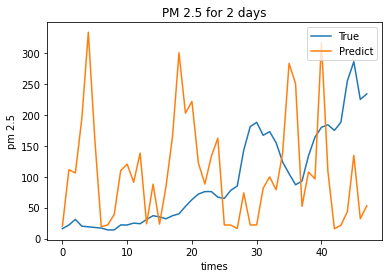

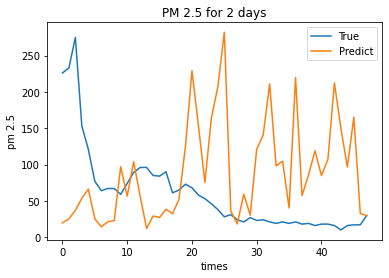

8152.335702494746
90.29028575929277


In [45]:
## last
import numpy

model.reset_state()
pm = test_y.reshape(-1, 1)

predict = numpy.array([])
for i in range(20):
    idx = i*batch_size
    xs = test_X[idx:idx+64].reshape(-1, 8)
    xs = scaler_x.transform(xs)
    xs = xs.reshape(64, 24, 8)
    p = model.predict(xs)
    k = p[:, -1]
    # l = scaler_y.inverse_transform(np.asnumpy(k))  # for cupy(GPU)

    predict = numpy.append(predict, k.reshape(-1))


for i in range(10):
    plt.title('PM 2.5 for 2 days')
    plt.plot(range(48), pm[i*48:i*48 + 48], label='True')
    plt.plot(range(48), predict[i*48:i*48 + 48], label='Predict')
    plt.xlabel('times')
    plt.ylabel('pm 2.5')
    plt.legend(loc='upper right')
    plt.show()

print(MSE(pm, predict))
print(np.sqrt(MSE(pm, predict)))